# Public Transport Demand Forecasting

## Data Processing ##

In [1]:
!pip install pandas fastparquet

import pandas as pd

URL_DATA = 'https://storage.data.gov.my/transportation/ridership_headline.parquet'

df = pd.read_parquet(URL_DATA)
if 'date' in df.columns: df['date'] = pd.to_datetime(df['date'])

print(df)

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Xin.Chen\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


           date  bus_rkl  bus_rkn  bus_rpn  rail_lrt_ampang  rail_mrt_kajang  \
0    2019-01-01     <NA>     <NA>     <NA>           113357           114173   
1    2019-01-02     <NA>     <NA>     <NA>           182715           169316   
2    2019-01-03     <NA>     <NA>     <NA>           187904           175304   
3    2019-01-04     <NA>     <NA>     <NA>           198420           187891   
4    2019-01-05     <NA>     <NA>     <NA>           120773           112660   
...         ...      ...      ...      ...              ...              ...   
2491 2025-10-27   217637     2197    49849           188362           231694   
2492 2025-10-28   226834     2191    50391           191938           246254   
2493 2025-10-29   246232     2020    49316           218432           285680   
2494 2025-10-30   243114     2092    46269           217969           285702   
2495 2025-10-31   239690     2191    51477           225355           291628   

      rail_lrt_kj  rail_monorail  rail_

In [2]:
na_summary = (
    df
    .isna()
    .sum()
    .to_frame(name="na_count")
    .assign(
        na_pct=lambda x: x.na_count / len(df)
    )
    .sort_values("na_count", ascending=False)
)

na_summary


,na_count,na_pct
rail_komuter,1713,0.686298
rail_tebrau,1265,0.506811
rail_mrt_pjy,1262,0.505609
bus_rpn,1096,0.439103
bus_rkl,1096,0.439103
bus_rkn,1096,0.439103
rail_komuter_utara,653,0.261619
rail_intercity,653,0.261619
rail_ets,653,0.261619
date,0,0.000000


In [3]:
start_dates = {}

for col in df.columns:
    if col == "date":
        continue
    first_valid = df.loc[df[col].notna(), "date"].min()
    start_dates[col] = first_valid

start_dates = (
    pd.Series(start_dates, name="first_available_date")
    .sort_values()
)

start_dates

rail_lrt_ampang      2019-01-01
rail_mrt_kajang      2019-01-01
rail_lrt_kj          2019-01-01
rail_monorail        2019-01-01
rail_ets             2020-10-15
rail_intercity       2020-10-15
rail_komuter_utara   2020-10-15
bus_rkl              2022-01-01
bus_rkn              2022-01-01
bus_rpn              2022-01-01
rail_mrt_pjy         2022-06-16
rail_tebrau          2022-06-19
rail_komuter         2023-09-10
Name: first_available_date, dtype: datetime64[ns]

In [4]:
df_filled = df.copy()

for col in df.columns:
    if col == "date":
        continue
    first_valid_date = df.loc[df[col].notna(), "date"].min()
    df_filled.loc[df["date"] < first_valid_date, col] = 0
    df_filled[col] = df_filled[col].fillna(0)

In [5]:
df_long = (
    df_filled
    .melt(
        id_vars="date",
        var_name="line",
        value_name="trips"
    )
)

In [6]:
def get_mode(line):
    if line.startswith("bus_"):
        return "bus"
    elif line.startswith("rail_"):
        return "rail"
    else:
        return "unknown"

df_long["mode"] = df_long["line"].apply(get_mode)

In [7]:
df_long["level"] = "service"

In [8]:
mode_level = (
    df_long
    .groupby(["date", "mode"], as_index=False)["trips"]
    .sum()
    .assign(level="mode", line="ALL")
)

total_level = (
    df_long
    .groupby("date", as_index=False)["trips"]
    .sum()
    .assign(level="total", mode="ALL", line="ALL")
)

In [9]:
df_long.info()
df_long.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32448 entries, 0 to 32447
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    32448 non-null  datetime64[ns]
 1   line    32448 non-null  object        
 2   trips   32448 non-null  Int64         
 3   mode    32448 non-null  object        
 4   level   32448 non-null  object        
dtypes: Int64(1), datetime64[ns](1), object(3)
memory usage: 1.3+ MB


,date,line,trips,mode,level
0,2019-01-01,bus_rkl,0,bus,service
1,2019-01-02,bus_rkl,0,bus,service
2,2019-01-03,bus_rkl,0,bus,service
3,2019-01-04,bus_rkl,0,bus,service
4,2019-01-05,bus_rkl,0,bus,service


In [10]:
df_long["date"].min(), df_long["date"].max()

(Timestamp('2019-01-01 00:00:00'), Timestamp('2025-10-31 00:00:00'))

## Exploratory Data Analysis ##

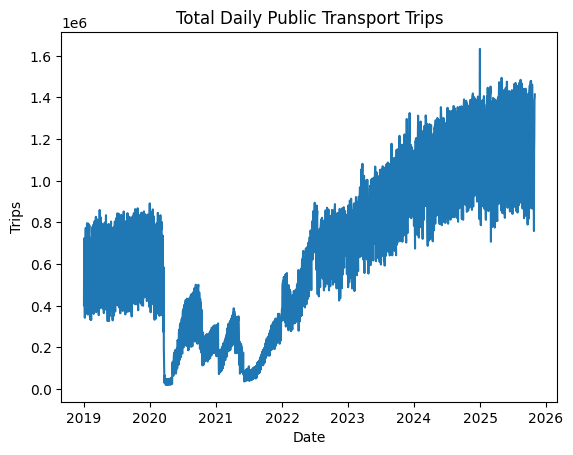

In [11]:
import matplotlib.pyplot as plt

daily_total = (
    df_long
    .groupby("date", as_index=False)["trips"]
    .sum()
)

plt.figure()
plt.plot(daily_total["date"], daily_total["trips"])
plt.title("Total Daily Public Transport Trips")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.show()

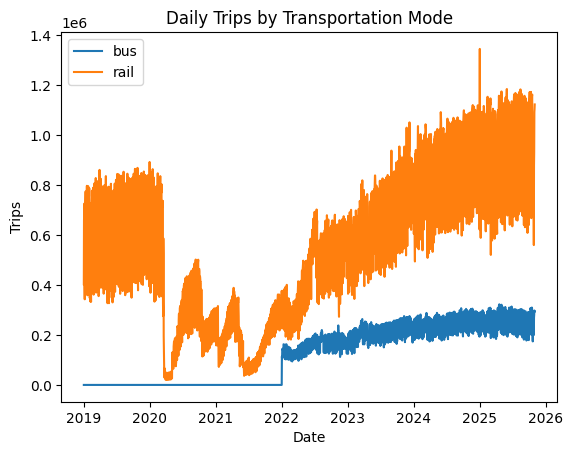

In [12]:
mode_daily = (
    df_long
    .groupby(["date", "mode"], as_index=False)["trips"]
    .sum()
)

plt.figure()
for mode, g in mode_daily.groupby("mode"):
    plt.plot(g["date"], g["trips"], label=mode)

plt.legend()
plt.title("Daily Trips by Transportation Mode")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.show()

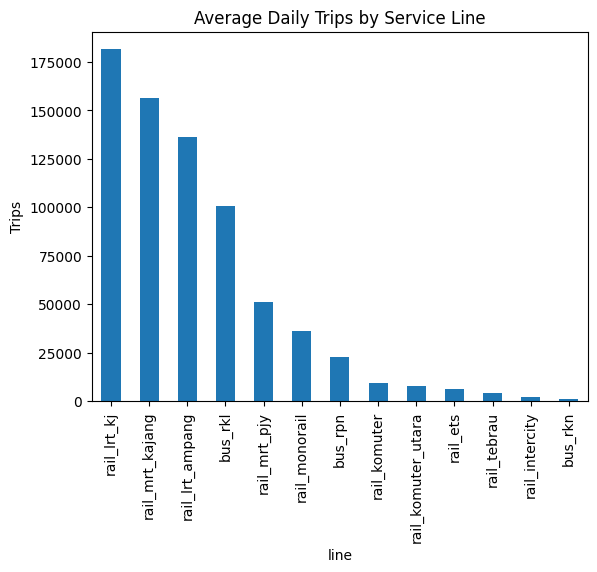

In [13]:
line_summary = (
    df_long
    .groupby("line")["trips"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure()
line_summary.plot(kind="bar")
plt.title("Average Daily Trips by Service Line")
plt.ylabel("Trips")
plt.show()

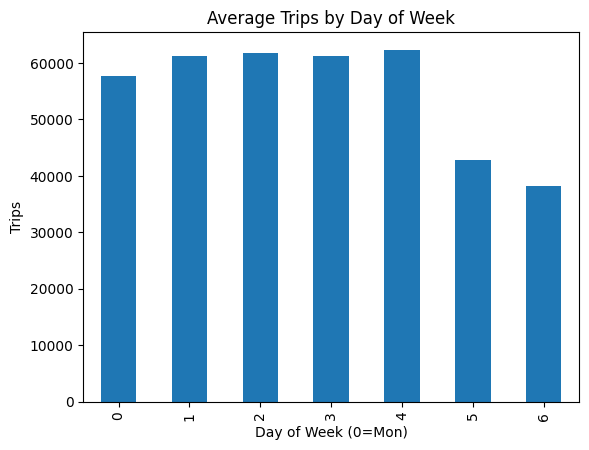

In [14]:
df_long["dow"] = df_long["date"].dt.dayofweek  # 0=Mon
dow_pattern = (
    df_long
    .groupby("dow")["trips"]
    .mean()
)

plt.figure()
dow_pattern.plot(kind="bar")
plt.title("Average Trips by Day of Week")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Trips")
plt.show()

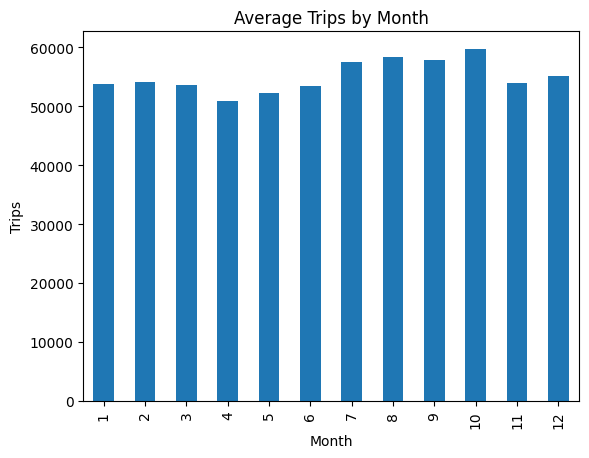

In [15]:
df_long["year"] = df_long["date"].dt.year
df_long["month"] = df_long["date"].dt.month

monthly_pattern = (
    df_long
    .groupby("month")["trips"]
    .mean()
)

plt.figure()
monthly_pattern.plot(kind="bar")
plt.title("Average Trips by Month")
plt.xlabel("Month")
plt.ylabel("Trips")
plt.show()


### Exploratory Data Analysis (EDA) Summary ###

This dataset captures daily public transportation trip counts across multiple bus and rail services over several years, forming a natural hierarchical structure (service → mode → total).

Key findings:

* Strong seasonality and regime changes
Total daily trips exhibit pronounced weekly and annual seasonality, along with a major structural break in early 2020 corresponding to COVID-19 mobility restrictions. Demand enters a low, volatile regime during 2020–2021 and shows a sustained recovery from 2022 onward, eventually exceeding pre-pandemic levels.

* Mode-level differences
Rail services account for the majority of trips and drive overall demand trends, while bus demand grows more gradually after becoming available later in the dataset. Recovery dynamics and volatility differ by mode, suggesting the need for mode-aware modeling.

* Highly heterogeneous service demand
A small number of major rail lines contribute most of the total demand, while many services operate at much lower volumes. This long-tail structure motivates hierarchical or grouped forecasting approaches rather than a single global model.

* Clear commuter patterns
Weekday demand is significantly higher than weekend demand, indicating a commuter-dominated system. Monthly aggregation reveals additional annual seasonality, with higher usage in the second half of the year.

* System evolution over time
Apparent missing values reflect periods when services were not yet operational or reported, rather than random data loss. This highlights the importance of respecting service start dates in analysis and modeling.

* Implications:
The EDA suggests that effective forecasting should account for calendar effects, structural breaks, and hierarchical relationships across services and modes.

## Feature Engineering ##

In [16]:
df_fe = df_long.copy()

df_fe["day_of_week"] = df_fe["date"].dt.dayofweek      # 0=Mon
df_fe["is_weekend"] = df_fe["day_of_week"].isin([5, 6]).astype(int)

df_fe["week"] = df_fe["date"].dt.isocalendar().week.astype(int)
df_fe["month"] = df_fe["date"].dt.month
df_fe["year"] = df_fe["date"].dt.year

In [17]:
import numpy as np

df_fe["dow_sin"] = np.sin(2 * np.pi * df_fe["day_of_week"] / 7)
df_fe["dow_cos"] = np.cos(2 * np.pi * df_fe["day_of_week"] / 7)

df_fe["month_sin"] = np.sin(2 * np.pi * df_fe["month"] / 12)
df_fe["month_cos"] = np.cos(2 * np.pi * df_fe["month"] / 12)

In [18]:
df_fe["post_2020"] = (df_fe["date"] >= "2020-03-01").astype(int)
df_fe["post_2022"] = (df_fe["date"] >= "2022-01-01").astype(int)

In [19]:
LAGS = [1, 7, 14, 28]

df_fe = df_fe.sort_values(["line", "date"])

for lag in LAGS:
    df_fe[f"lag_{lag}"] = (
        df_fe
        .groupby("line")["trips"]
        .shift(lag)
    )

In [20]:
WINDOWS = [7, 14, 28]

for w in WINDOWS:
    df_fe[f"roll_mean_{w}"] = (
        df_fe
        .groupby("line")["trips"]
        .shift(1)
        .rolling(w)
        .mean()
    )
    
    df_fe[f"roll_std_{w}"] = (
        df_fe
        .groupby("line")["trips"]
        .shift(1)
        .rolling(w)
        .std()
    )

In [21]:
mode_daily = (
    df_fe
    .groupby(["date", "mode"], as_index=False)["trips"]
    .sum()
    .rename(columns={"trips": "mode_trips"})
)

df_fe = df_fe.merge(
    mode_daily,
    on=["date", "mode"],
    how="left"
)

In [22]:
service_start = (
    df_fe[df_fe["trips"] > 0]
    .groupby("line")["date"]
    .min()
    .rename("service_start")
)

df_fe = df_fe.merge(service_start, on="line", how="left")

df_fe["days_since_launch"] = (
    (df_fe["date"] - df_fe["service_start"])
    .dt.days
    .clip(lower=0)
)

In [23]:
df_model = df_fe.dropna().reset_index(drop=True)

## Train, Validate, Test ##

In [24]:
SPLIT_DATE = "2024-01-01"

train_df = df_model[df_model["date"] < SPLIT_DATE]
test_df  = df_model[df_model["date"] >= SPLIT_DATE]

train_df.shape, test_df.shape

((23374, 30), (8710, 30))

In [25]:
TARGET = "trips"

DROP_COLS = [
    "date",
    "trips",
    "service_start",
    "line",
    "mode",
    "level"
]

FEATURES = [c for c in train_df.columns if c not in DROP_COLS]

FEATURES

['dow',
 'year',
 'month',
 'day_of_week',
 'is_weekend',
 'week',
 'dow_sin',
 'dow_cos',
 'month_sin',
 'month_cos',
 'post_2020',
 'post_2022',
 'lag_1',
 'lag_7',
 'lag_14',
 'lag_28',
 'roll_mean_7',
 'roll_std_7',
 'roll_mean_14',
 'roll_std_14',
 'roll_mean_28',
 'roll_std_28',
 'mode_trips',
 'days_since_launch']

In [26]:
test_df["pred_naive_7d"] = test_df["lag_7"]

from sklearn.metrics import mean_absolute_error

baseline_mae = mean_absolute_error(
    test_df[TARGET],
    test_df["pred_naive_7d"]
)

baseline_mae

C:\Users\Xin.Chen\AppData\Local\Temp\ipykernel_12532\4044980561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["pred_naive_7d"] = test_df["lag_7"]


7821.950287026407

In [27]:
validation_years = [2021, 2022, 2023]

In [28]:
from sklearn.metrics import mean_absolute_error

def evaluate_model(model, df, features, target, val_year):
    train = df[df["date"].dt.year < val_year]
    val   = df[df["date"].dt.year == val_year]
    
    model.fit(train[features], train[target])
    preds = model.predict(val[features])
    
    return mean_absolute_error(val[target], preds)

In [29]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

models = {
    "ridge": Ridge(alpha=1.0),

    "gbr": GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    ),

    "xgb": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )
}


models["lgbm"] = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [30]:
from sklearn.metrics import mean_absolute_error

results = {}

for name, model in models.items():
    fold_mae = []
    for year in validation_years:
        mae = evaluate_model(
            model,
            train_df,      # data BEFORE test split
            FEATURES,
            TARGET,
            year
        )
        fold_mae.append(mae)
    results[name] = fold_mae

import pandas as pd

results_df = (
    pd.DataFrame(results, index=validation_years)
    .rename_axis("validation_year")
)

results_df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3183
[LightGBM] [Info] Number of data points in the train set: 9139, number of used features: 23
[LightGBM] [Info] Start training from score 37204.317868
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3184
[LightGBM] [Info] Number of data points in the train set: 13884, number of used features: 23
[LightGBM] [Info] Start training from score 29736.211971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is no

,ridge,gbr,xgb,lgbm
validation_year,,,,
2021,2907.566398,1572.957066,1742.210571,1881.454010
2022,5595.333213,9671.655653,9544.655273,9872.227110
2023,6730.823263,15116.693726,14558.839844,14934.731104


In [31]:
summary_df = (
    results_df
    .agg(["mean", "std"])
    .T
    .sort_values("mean")
)

summary_df


,mean,std
ridge,5077.907625,1963.446000
xgb,8615.235229,6458.665705
gbr,8787.102148,6815.058830
lgbm,8896.137408,6581.152943


In [32]:
summary_df["improvement_vs_baseline"] = baseline_mae - summary_df["mean"]
summary_df

,mean,std,improvement_vs_baseline
ridge,5077.907625,1963.446000,2744.042662
xgb,8615.235229,6458.665705,-793.284942
gbr,8787.102148,6815.058830,-965.151861
lgbm,8896.137408,6581.152943,-1074.187121


In [33]:
import numpy as np

alphas = np.logspace(-2, 4, 10)
alphas

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

alpha_results = {}

for alpha in alphas:
    fold_mae = []
    for year in validation_years:
        model = Ridge(alpha=alpha)
        
        train = train_df[train_df["date"].dt.year < year]
        val   = train_df[train_df["date"].dt.year == year]
        
        model.fit(train[FEATURES], train[TARGET])
        preds = model.predict(val[FEATURES])
        
        mae = mean_absolute_error(val[TARGET], preds)
        fold_mae.append(mae)
    
    alpha_results[alpha] = {
        "mean_mae": np.mean(fold_mae),
        "std_mae": np.std(fold_mae)
    }

alpha_df = (
    pd.DataFrame(alpha_results)
    .T
    .sort_values("mean_mae")
)

alpha_df

C:\Users\Xin.Chen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.15498e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
C:\Users\Xin.Chen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.62066e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
C:\Users\Xin.Chen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=8.30621e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
C:\Users\Xin.Chen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\loc

,mean_mae,std_mae
10000.000000,4693.049684,1738.782633
2154.434690,4778.479653,1805.057344
464.158883,4842.074515,1840.637221
100.000000,4938.747544,1765.609836
21.544347,5032.692373,1657.995216
4.641589,5068.873085,1614.190816
1.000000,5077.907625,1603.146946
0.215443,5079.914438,1600.690110
0.046416,5080.349614,1600.157151
0.010000,5080.443645,1600.041961


In [34]:
from sklearn.linear_model import Ridge

final_model = Ridge(alpha=10000)

final_model.fit(
    train_df[FEATURES],
    train_df[TARGET]
)

test_df["pred_ridge"] = final_model.predict(
    test_df[FEATURES]
)

from sklearn.metrics import mean_absolute_error

final_test_mae = mean_absolute_error(
    test_df[TARGET],
    test_df["pred_ridge"]
)

final_test_mae

C:\Users\Xin.Chen\AppData\Local\Temp\ipykernel_12532\1079335253.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["pred_ridge"] = final_model.predict(


8069.833472724199

In [35]:
test_df["pred_naive_7d"] = test_df["lag_7"]

baseline_test_mae = mean_absolute_error(
    test_df[TARGET],
    test_df["pred_naive_7d"]
)

baseline_test_mae, final_test_mae

C:\Users\Xin.Chen\AppData\Local\Temp\ipykernel_12532\2462824642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["pred_naive_7d"] = test_df["lag_7"]


(7821.950287026407, 8069.833472724199)

## Final Forecast ##

In [36]:
mode_test = (
    test_df
    .groupby(["date", "mode"], as_index=False)
    .agg(
        actual=("trips", "sum"),
        ridge=("pred_ridge", "sum"),
        naive=("pred_naive_7d", "sum")
    )
)

mode_test.head()

from sklearn.metrics import mean_absolute_error

mode_mae = (
    mode_test
    .groupby("mode")
    .apply(lambda x: pd.Series({
        "ridge_mae": mean_absolute_error(x["actual"], x["ridge"]),
        "naive_mae": mean_absolute_error(x["actual"], x["naive"])
    }))
)

mode_mae

C:\Users\Xin.Chen\AppData\Local\Temp\ipykernel_12532\1597341394.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


,ridge_mae,naive_mae
mode,,
bus,15997.319868,18048.974627
rail,65809.404505,72531.232836


In [37]:
total_test = (
    test_df
    .groupby("date", as_index=False)
    .agg(
        actual=("trips", "sum"),
        ridge=("pred_ridge", "sum"),
        naive=("pred_naive_7d", "sum")
    )
)

total_test.head()
total_ridge_mae = mean_absolute_error(
    total_test["actual"],
    total_test["ridge"]
)

total_naive_mae = mean_absolute_error(
    total_test["actual"],
    total_test["naive"]
)

total_ridge_mae, total_naive_mae

(78776.80063712825, 87793.94776119402)

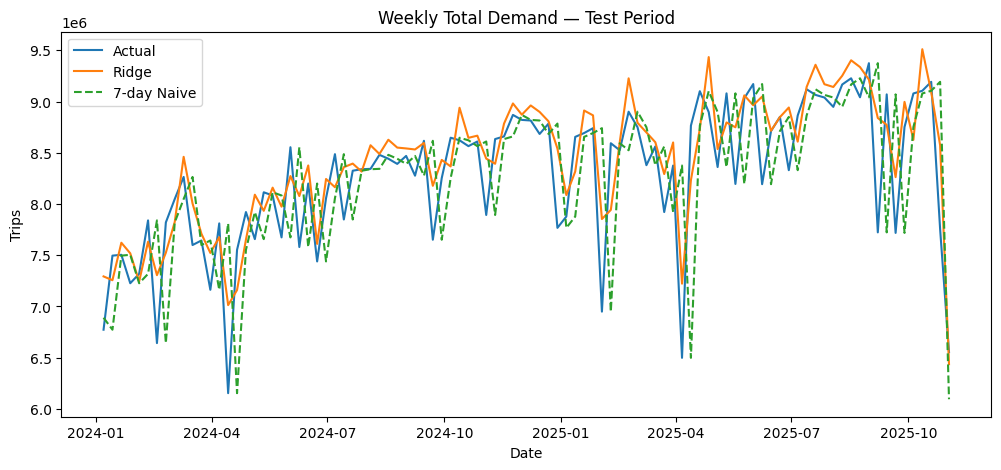

In [38]:
weekly_test = (
    total_test
    .set_index("date")
    .resample("W")
    .sum()
    .reset_index()
)
plt.figure(figsize=(12, 5))
plt.plot(weekly_test["date"], weekly_test["actual"], label="Actual")
plt.plot(weekly_test["date"], weekly_test["ridge"], label="Ridge")
plt.plot(
    weekly_test["date"],
    weekly_test["naive"],
    linestyle="--",
    label="7-day Naive"
)

plt.legend()
plt.title("Weekly Total Demand — Test Period")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.show()